In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio, display
import cmath
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%run "NN Audio Core.py"

In [3]:
# Round trip test with no NN evaluation to test pipeline
# Have to get phase information from the noisy file to match what happens for real

file = "p232_013.wav"
clean_file = "Assets\\DataShareArchive\\Test\\Clean\\" + file
noisy_file = "Assets\\DataShareArchive\\Test\\Noisy\\" + file
wav, rate = librosa.core.load(clean_file)
noisy_wav, rate = librosa.core.load(noisy_file)

In [4]:
ft = get_ft(wav)
print(ft.shape)
swav = inv_ft(ft)
Audio(swav,rate=22050)

(513, 340)


In [5]:
Audio(wav, rate=22050)

In [6]:
print(FMIN, N_FFT)
freq = librosa.fft_frequencies(sr=22050, n_fft=N_FFT)
print(freq.shape)
print(freq[292], freq[3])

32.70319566257483 1024
(513,)
6287.6953125 64.599609375


In [112]:
import math

# Low cut off at bin 3 ~65hz (C2) - seems like 125hz should be safe but keeping the low end
# High cut off bin 300 ~6500hz - 5000hz sounded OK, but keeping some just in case
# These are based on N_FFT 1024
LOW_BIN = 3 
HIGH_BIN = 340
SAMPLE_BINS = HIGH_BIN-LOW_BIN

freq = librosa.fft_frequencies(sr=22050, n_fft=N_FFT)
LOW_FREQ = freq[LOW_BIN]
HIGH_FREQ = freq[HIGH_BIN]
SAMPLE_OCTAVES = math.log(HIGH_FREQ/LOW_FREQ,2)
BINS_PER_OCTAVE = 70


# Number of bins in rescaled pitch representation of the ft
# No idea - need to test
PITCH_BINS = math.floor(SAMPLE_OCTAVES * BINS_PER_OCTAVE)

# S = sample space, which is frequency  P = pitch space, which is rescaled so pitches are constant space appart
def S_ix(p_ix):
    return SAMPLE_OCTAVES * ((SAMPLE_BINS/SAMPLE_OCTAVES + 1)**(p_ix/PITCH_BINS) -1 )

def P_ix(s_ix):
    return PITCH_BINS * math.log((1+s_ix/SAMPLE_OCTAVES),2)/math.log((1 + SAMPLE_BINS/SAMPLE_OCTAVES),2)

# Super dumb sampler that just takes the closest fit
def samples_to_pitch(bins, p_ix):
    s_ix = math.floor(S_ix(p_ix))
    return bins[s_ix]

def pitch_to_samples(pt, s_ix):
    p_ix = math.floor(P_ix(s_ix))
    return pt[p_ix]

# Takes samples and rescales to pitch (log of frequencies so space between same pitch is constant)
# Output is samples, then rescaled magnitudes in shape (sample_count, PITCH_BINS)
def pitch_scale(ft):
    pt = np.empty((ft.shape[0], PITCH_BINS))
    for s in range(ft.shape[0]):
        for i in range(PITCH_BINS):
            pt[s,i] = samples_to_pitch(ft[s,:],i)
    return pt

def sample_scale(pt):
    ft = np.empty((pt.shape[0], SAMPLE_BINS))
    for s in range(pt.shape[0]):
        for i in range(SAMPLE_BINS):
            ft[s,i] = pitch_to_samples(pt[s,:],i)
    return ft

# Sample output is ft converted to magnitude and .T to get samples then ft
# Only returns 'interesting' samples - between LOW_ and HIGH_ bins, so output shape is (sample_count, SAMPLE_BINS)
def get_samples(file):
    wav, rate = librosa.core.load(file)
    samples = abs(get_ft(wav).T) # organized as bins, frames so we need to transpose them to frames, bins
    return samples[:,LOW_BIN:HIGH_BIN]

def rebuild_fft(output, original_fft):
    fft = np.zeros((output.shape[0], FFT_BINS))
    fft[:,LOW_BIN:HIGH_BIN] = output
    vphase = np.vectorize(cmath.phase)
    o_phase = vphase(original_fft)
    mag = fft.T
    vrect = np.vectorize(cmath.rect)
    return vrect(mag, o_phase)

7321.2890625 64.599609375 6.824428435416546 477 337


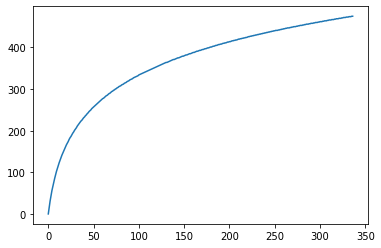

[0, 16] [470, 470, 471, 471, 472, 472, 472, 473, 473, 473, 474, 474, 474, 475, 475] 337


In [113]:
S = get_samples(clean_file)

s = list(range(SAMPLE_BINS))
p = [math.floor(P_ix(x)) for x in s]
print(HIGH_FREQ, LOW_FREQ, SAMPLE_OCTAVES, PITCH_BINS, SAMPLE_BINS)

plt.plot(s,p)
plt.show()
print(p[:2],p[-15:], len(p))

In [126]:
# Project X onto returned array Y using a list of ascending ys of len(X) with maximum value of leng(Y), so that
# where multiple ys's map to a single index i in X, assign X[i] to Y[those ys's]
# where a single yx maps to multiple indices in X, assign X[these i's] of X[ys]
def squash_stretch(ys, X):
    Y = np.empty((math.floor(ys[-1])+1))
    yl = 0
    i = 0
    while i < (len(ys)-1):
        xh = i
        if (math.floor(ys[i+1]) > math.floor(ys[i]+1)):
            print("Batch assigning X[i] to Y[ys[i]:ys[i+1]] ",i, ys[i], ys[i+1])
            Y[ys[i]:ys[i+1]] = X[i]
            i += 1
        else:
            while (math.floor(ys[i]) == math.floor(ys[xh])) and (xh < len(ys)-1):
                xh += 1
            if (xh > i+1):
                Y[ys[i]] = 0
                print("Averaging X[i,xh] into Y[ys[i]] ", i, xh, ys[i])
                Y[ys[i]] = np.average(X[i:xh])
                i = xh
            else:
                print("Straight map X[i] to Y[ys[i]] ", i, ys[i])
                Y[ys[i]] = X[i]
                i += 1
        print (i, ys[i], ys[xh])
    return Y

In [127]:
St = S[0,:]
print(len(p), p[-1], St.shape)
Pt = squash_stretch(p,St)

337 475 (337,)
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  0 0 16
1 16 0
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  1 16 31
2 31 16
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  2 31 44
3 44 31
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  3 44 56
4 56 44
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  4 56 66
5 66 56
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  5 66 76
6 76 66
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  6 76 85
7 85 76
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  7 85 94
8 94 85
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  8 94 102
9 102 94
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  9 102 109
10 109 102
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  10 109 116
11 116 109
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  11 116 123
12 123 116
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  12 123 129
13 129 123
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  13 129 135
14 135 129
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  14 135 141
15 141 135
Batch assigning X[i] to Y[ys[i]:ys[i+1]]  15 141 146
16 146 141
Batch assigning 

In [119]:
print(Pt.shape, Pt)

(476,) [4.50836301e-01 4.50836301e-01 4.50836301e-01 4.50836301e-01
 4.50836301e-01 4.50836301e-01 4.50836301e-01 4.50836301e-01
 4.50836301e-01 4.50836301e-01 4.50836301e-01 4.50836301e-01
 4.50836301e-01 4.50836301e-01 4.50836301e-01 4.50836301e-01
 2.11938754e-01 2.11938754e-01 2.11938754e-01 2.11938754e-01
 2.11938754e-01 2.11938754e-01 2.11938754e-01 2.11938754e-01
 2.11938754e-01 2.11938754e-01 2.11938754e-01 2.11938754e-01
 2.11938754e-01 2.11938754e-01 2.11938754e-01 6.35760874e-02
 6.35760874e-02 6.35760874e-02 6.35760874e-02 6.35760874e-02
 6.35760874e-02 6.35760874e-02 6.35760874e-02 6.35760874e-02
 6.35760874e-02 6.35760874e-02 6.35760874e-02 6.35760874e-02
 1.17273526e-02 1.17273526e-02 1.17273526e-02 1.17273526e-02
 1.17273526e-02 1.17273526e-02 1.17273526e-02 1.17273526e-02
 1.17273526e-02 1.17273526e-02 1.17273526e-02 1.17273526e-02
 2.90036742e-02 2.90036742e-02 2.90036742e-02 2.90036742e-02
 2.90036742e-02 2.90036742e-02 2.90036742e-02 2.90036742e-02
 2.90036742e-02 2

337


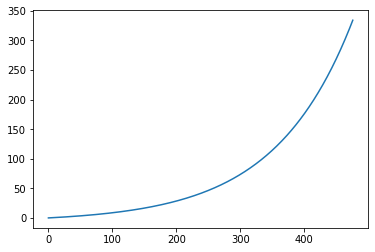

[0.0, 0.056308988386587565, 0.11308258742931002, 0.17032463067353856, 0.22803898329557876, 0.28622954236366766, 0.34490023710110734, 0.4040550291515851, 0.46369791284667405, 0.5238329154755483, 0.5844640975569139, 0.645595553113194, 0.707231409946966, 0.7693758299196866, 0.8320330092327183, 0.8952071787106627, 0.9589026040870505, 1.023123586292373, 1.0878744617444907, 1.153159602641454] [331.39560443783904, 334.1862891205788]


In [358]:
p = list(range(PITCH_BINS))
s = [S_ix(x) for x in p]
print(SAMPLE_BINS)

plt.plot(p,s)
plt.show()
print(s[:20],s[-2:])

In [359]:
#for i in range(PITCH_BINS):
#    print("pitch %d maps to sample %.2f" % (i, S_ix(i)))

In [351]:
samples = get_samples(clean_file)
print(samples.shape)
pt = pitch_scale(samples)
print(pt.shape)
s2 = sample_scale(pt)
print(s2.shape)
wav = rebuild_fft(s2, noisy_ft)

(340, 337)
(340, 682)
(340, 337)


(340, 337)
round trip
pitch space view


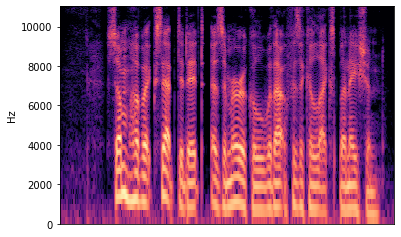

In [352]:
samples = get_samples(clean_file)

print(samples.shape)

noisy_ft = get_ft(noisy_wav)

pt = pitch_scale(samples)
s2 = sample_scale(pt)
rt = rebuild_fft(s2, noisy_ft)
rwav = inv_ft(rt)

print("round trip")
print("pitch space view")
librosa.display.specshow(librosa.amplitude_to_db(np.abs(pt).T, ref=np.max), y_axis='linear')

Audio(rwav,rate=22050)

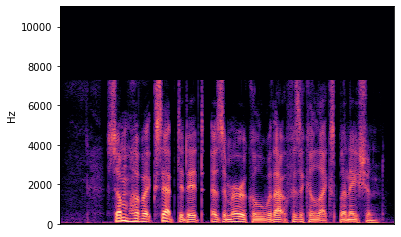

In [354]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(rt), ref=np.max), y_axis='linear')


Clean


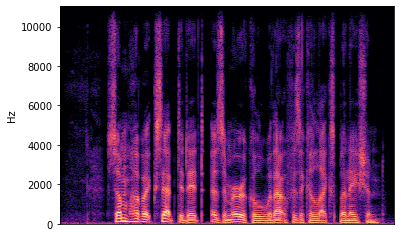

In [345]:
print("Clean")
wav, rate = librosa.core.load(clean_file)
ft = get_ft(wav)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(ft), ref=np.max), y_axis='linear')
Audio(wav,rate=22050)

In [295]:
noisy_ft = get_ft(noisy_wav)
noisy_ft.shape

r = noisy_ft.real
i = noisy_ft.imag
samples = np.empty((r.shape[0], r.shape[1],2))
samples[:,:,0] = r
samples[:,:,1] = i

print(samples.shape)


(513, 340, 2)


In [ ]:
# Compare to clean
display_fft(get_ft(wav))
Audio(wav,rate=22050)

In [ ]:
# Compare to noisy
display_fft(noisy_ft)
Audio(noisy_wav,rate=22050)

In [ ]:
wav, rate = librosa.core.load("Assets\\DataShareArchive\\Test\\clean\\p232_011.wav")

#draw("p232_010.wav", "clean")

c_f = get_ft(wav)

def filter(cqt):
    cqt[0:BINS_PER_OCTAVE,:] = 0
    return cqt

c_f = filter(c_f)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(c_f), ref=np.max), y_axis='cqt_hz')

print(c_f.shape)

rewav = inv_ft(c_f)

Audio(rewav, rate=rate)


In [ ]:
Audio(wav, rate=rate)

In [ ]:
n_f = draw("p232_010.wav", "noisy")

In [ ]:
# CQT experiments

hop_length = 256
bins_per_octave = 12 * 8
fmin = librosa.note_to_hz('C1')
octaves = 8
C = librosa.cqt(wav, hop_length=hop_length, fmin=fmin, n_bins=octaves*bins_per_octave, bins_per_octave=bins_per_octave)
print(C.shape)

C[0:bins_per_octave,:] = 0
fade = bins_per_octave//2
for i in range(0,fade):
    C[bins_per_octave+i,:] = (i/fade) * C[bins_per_octave+i,:]

rewav = librosa.icqt(C, hop_length=hop_length, bins_per_octave=bins_per_octave)


librosa.display.specshow(librosa.amplitude_to_db(np.abs(C), ref=np.max), y_axis='cqt_note', x_axis='time', hop_length=hop_length, fmin=fmin,  bins_per_octave=bins_per_octave)


Audio(rewav, rate=rate)


In [ ]:
# polar experiments
import cmath

n_f_m = abs(n_f)
c_f_m = abs(c_f)
vphase = np.vectorize(cmath.phase)
x = vphase(n_f)
print(x)

mag_ratio = c_f_m/n_f_m

re_f = n_f * mag_ratio

rewav = librosa.istft(re_f, hop_length=256)

Audio(rewav, rate=rate)

# this works for full complex numbers
#diff = n_f - c_f
#reclean = n_f - diff
#real_clean = c_f.real + 1j * c_f.imag


In [ ]:
Audio(wav, rate=rate)


In [ ]:
librosa.display.specshow(librosa.amplitude_to_db(np.abs(diff), ref=np.max), y_axis='log', x_axis='time')

In [ ]:
round_trip = librosa.istft(real_clean)
Audio(round_trip, rate=rate)

In [ ]:
round_trip = librosa.istft(X)
Audio(round_trip, rate=rate)

In [ ]:
(3.14/2 + 3.14/2) % 6.28

In [ ]:
ft_freq = librosa.fft_frequencies(sr=22050, n_fft=N_FFT)

delta = ft_freq[1:] - ft_freq[0:-1]
print(delta)